In [1]:
%matplotlib inline

In [2]:

path = '/Users/IS/desktop/training_data 2/raw_images/'

In [3]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

In [4]:
import utils; reload(utils)
from utils import plots

Using Theano Backend.


In [5]:

batch_size=64

In [6]:

import vgg16; reload(vgg16)
from vgg16 import Vgg16

In [ ]:
vgg = Vgg16()

batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)
vgg.finetune(batches)
vgg.fit(batches, val_batches, nb_epoch=1)

In [8]:
vgg = Vgg16()

In [9]:
batches = vgg.get_batches(path+'train', batch_size=4)

Found 1800 images belonging to 2 classes.


Note :'classes', it doesn't mean python classes - but rather it refers to the categories of the labels, such as 'pug', or 'tabby'.)

*Batches* is just a regular python iterator. Each iteration returns both the images themselves, as well as the labels.

In [10]:
imgs,labels = next(batches)

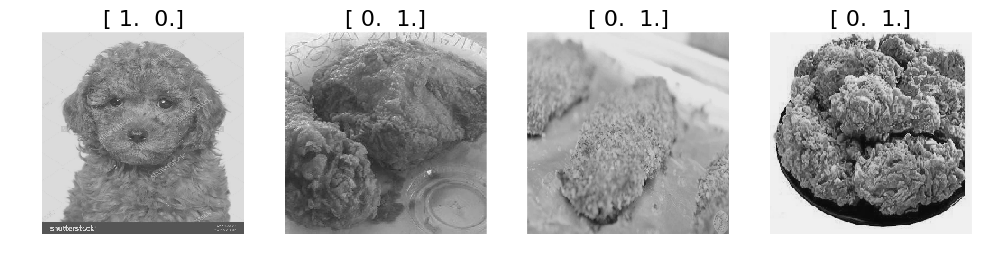

In [11]:
plots(imgs, titles=labels)

We can now pass the images to Vgg16's predict() function to get back probabilities, category indexes, and category names for each image's VGG prediction.

In [12]:
vgg.predict(imgs, True)

(array([ 0.477 ,  0.0779,  0.194 ,  0.8347], dtype=float32),
 array([265, 666, 181, 938]),
 [u'toy_poodle', u'mortar', u'Bedlington_terrier', u'cauliflower'])

The category indexes are based on the ordering of categories used in the VGG model - e.g here are the first four:

In [13]:
vgg.classes[:4]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark']

(Note that, other than creating the Vgg16 object, none of these steps are necessary to build a model; they are just showing how to use the class to view imagenet predictions.)

In [14]:
batch_size=64

In [15]:
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size)

Found 1800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [16]:
vgg.finetune(batches)

Finally, we *fit()* the parameters of the model using the training data, reporting the accuracy on the validation set after every epoch. (An *epoch* is one full pass through the training data.)

In [17]:
vgg.fit(batches, val_batches, nb_epoch=1)

Epoch 1/1
1800/1800 [==============================] - 2462s - loss: 0.1670 - acc: 0.9389 - val_loss: 0.0037 - val_acc: 1.0000


## Model setup

We need to import all the modules we'll be using from numpy, scipy, and keras:

In [18]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

In [19]:
FILES_PATH = 'http://www.platform.ai/models/'; CLASS_FILE='imagenet_class_index.json'
# Keras' get_file() is a handy function that downloads files, and caches them for re-use later
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
with open(fpath) as f: class_dict = json.load(f)
# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

Here's a few examples of the categories we just imported:

In [20]:
classes[:5]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']

## Model creation

Creating the model involves creating the model architecture, and then loading the model weights into that architecture. We will start by defining the basic pieces of the VGG architecture.

VGG has just one type of convolutional block, and one type of fully connected ('dense') block. Here's the convolutional block definition:

In [21]:
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

...and here's the fully-connected definition.

In [22]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

In [23]:
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # reverse axis bgr->rgb

In [24]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

In [25]:
model = VGG_16()

In [26]:
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

## Getting imagenet predictions

The setup of the imagenet model is now complete, so all we have to do is grab a batch of images and call *predict()* on them.

In [27]:
batch_size = 4

In [28]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(224,224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

Found 1800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


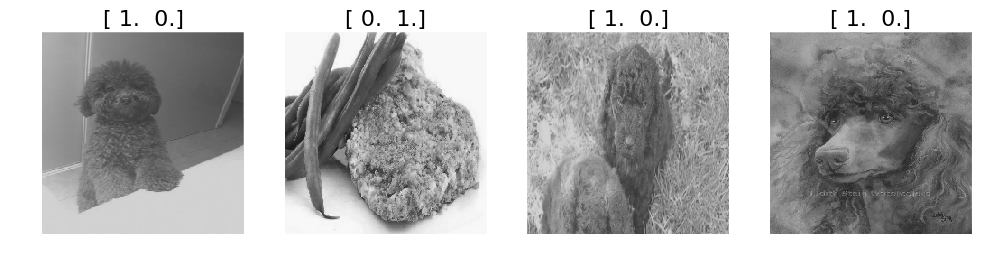

In [29]:
batches = get_batches('train', batch_size=batch_size)
val_batches = get_batches('valid', batch_size=batch_size)
imgs,labels = next(batches)

# 'ground truth'
plots(imgs, titles=labels)

The VGG model returns 1,000 probabilities for each image, representing the probability that the model assigns to each possible imagenet category for each image. By finding the index with the largest probability (with *np.argmax()*) we can find the predicted label.

In [30]:
def pred_batch(imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)

    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(classes[:5]))
    print('First 5 probabilities: {}\n'.format(preds[0, :5]))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))

In [31]:
pred_batch(imgs)

Shape: (4, 1000)
First 5 classes: [u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']
First 5 probabilities: [  9.5175e-08   2.2699e-06   2.3340e-07   1.6987e-07   3.8721e-07]

Predictions prob/class: 
  0.5852/toy_poodle
  0.0800/nail
  0.0705/hyena
  0.6457/standard_poodle Found 23000 images belonging to 2 classes.